In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver

#### Topology Setup

In [24]:
seed = 4
np.random.seed(seed)

device_number = 1000
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(device_number, centers, X_dim_range, Y_dim_range, seed)
coord_dict = {"sim(1000)": coords_df}

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=10)
c_coords = coords_df.iloc[0][["x", "y"]]

Creating df for sim(1000)
Optimal k is 20
Done


In [25]:
coords_df

,x,y,latency
0,71.925332,25.565323,0.000000
1,24.775013,11.958341,49.074459
2,5.770977,8.497964,68.320520
3,30.952786,-3.329505,50.136420
4,18.231240,4.925715,57.524334
...,...,...,...
996,88.052679,11.635696,21.310228
997,34.643330,-22.089226,60.505403
998,20.830278,17.439655,51.737134
999,36.871673,9.978153,38.362988


In [26]:
random.seed(seed)
items = range(1, coords_df.shape[0])
# Number of times to randomly select and remove elements
iterations = 10
# Number of elements to select and remove each time
num_changes = 20
changed_nodes_dict = {}

# Perform the random selection and removal x times
for i in range(1, iterations + 1):
    if len(items) >= num_changes:
        selected_elements = random.sample(items, num_changes)
        changed_nodes_dict[i] = selected_elements
        items = [element for element in items if element not in selected_elements]
print(changed_nodes_dict)

{1: [242, 311, 106, 739, 406, 491, 159, 93, 69, 21, 412, 563, 940, 297, 820, 784, 61, 228, 533, 550], 2: [379, 292, 817, 183, 866, 114, 277, 226, 986, 970, 28, 868, 673, 846, 275, 839, 287, 205, 175, 328], 3: [317, 671, 926, 780, 913, 906, 939, 404, 94, 903, 649, 367, 717, 422, 545, 269, 193, 268, 510, 306], 4: [98, 890, 945, 600, 916, 335, 8, 991, 325, 626, 766, 962, 347, 924, 832, 559, 213, 457, 467, 654], 5: [326, 483, 505, 178, 258, 345, 290, 900, 883, 48, 89, 51, 517, 696, 316, 580, 596, 719, 526, 775], 6: [396, 163, 763, 221, 76, 473, 230, 723, 720, 504, 319, 208, 411, 499, 847, 670, 372, 722, 637, 224], 7: [384, 118, 978, 71, 824, 265, 331, 889, 681, 716, 278, 140, 392, 202, 346, 541, 30, 47, 424, 811], 8: [100, 352, 875, 804, 400, 20, 395, 355, 394, 180, 925, 778, 497, 743, 809, 975, 92, 360, 740, 231], 9: [553, 368, 164, 309, 476, 732, 191, 420, 699, 11, 455, 54, 566, 204, 456, 957, 982, 454, 365, 698], 10: [123, 564, 259, 544, 141, 74, 78, 68, 921, 210, 749, 849, 185, 761, 50

In [27]:
coord_list = [coords_df]

orig_df = coords_df.copy()
for i, node_ids in changed_nodes_dict.items():
    update_df = topology.coords_sim(device_number, centers, X_dim_range, Y_dim_range, with_latency=True,
                                    c_coords=c_coords)
    update_df = update_df.loc[node_ids]
    orig_df.loc[update_df.index] = update_df
    coord_list.append(orig_df.copy())

len(coord_list)

11

In [28]:
changed_nodes_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [29]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster
0,71.925332,25.565323,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1
1,24.775013,11.958341,49.074459,worker,9223372036854775807,1,50,48,49,44,42,54,40,34,34,73,27,77,1
2,5.770977,8.497964,68.320520,worker,9223372036854775807,1,50,53,48,42,44,59,52,57,42,34,11,27,1
3,30.952786,-3.329505,50.136420,worker,9223372036854775807,1,50,49,54,44,47,43,37,58,28,38,27,8,15
4,18.231240,4.925715,57.524334,worker,9223372036854775807,27,50,49,55,44,48,58,51,35,33,17,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,88.052679,11.635696,21.310228,worker,9223372036854775807,1,50,48,51,52,58,62,75,47,59,17,38,39,9
997,34.643330,-22.089226,60.505403,worker,9223372036854775807,1,50,52,50,47,50,48,40,48,28,27,30,119,13
998,20.830278,17.439655,51.737134,worker,9223372036854775807,1,50,49,47,57,53,57,66,38,26,99,94,154,1
999,36.871673,9.978153,38.362988,worker,9223372036854775807,12,50,50,49,53,40,54,33,38,44,79,59,4,15


In [30]:
coord_list[1]

,x,y,latency
0,71.925332,25.565323,0.000000
1,24.775013,11.958341,49.074459
2,5.770977,8.497964,68.320520
3,30.952786,-3.329505,50.136420
4,18.231240,4.925715,57.524334
...,...,...,...
996,88.052679,11.635696,21.310228
997,34.643330,-22.089226,60.505403
998,20.830278,17.439655,51.737134
999,36.871673,9.978153,38.362988


In [31]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 5971 Available: 50050


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

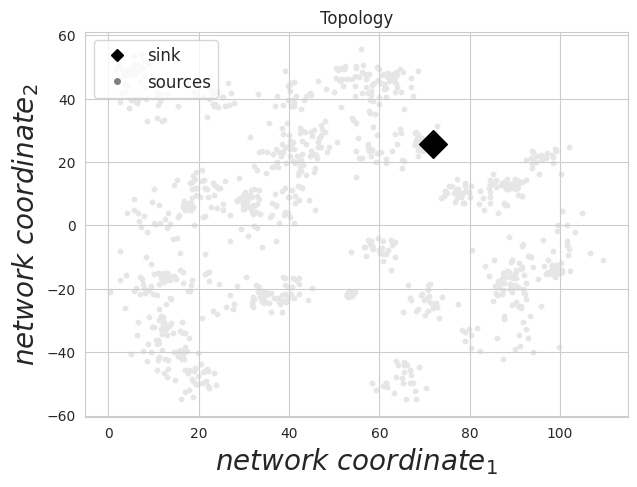

In [32]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

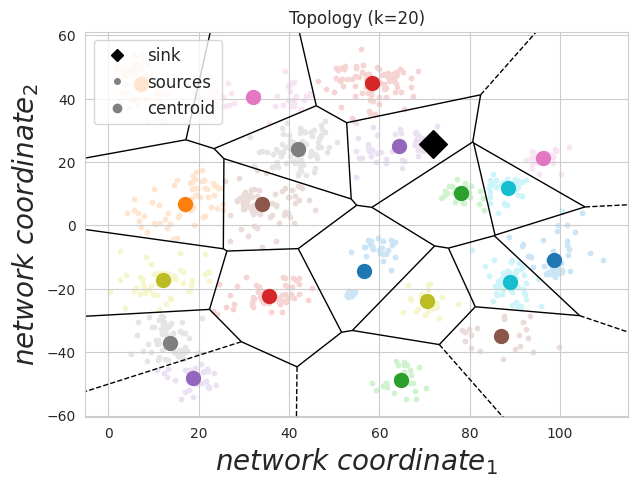

In [33]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Changing Topology

In [34]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
}

In [35]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight"

df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col,
                                               merge_factor=param_dict[weight_col][
                                                   "merge_factor"],
                                               step_size=param_dict[weight_col]["step_size"],
                                               with_eval=False)
placement_df = df_dict[slot_col]

Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.4, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 20 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  130
--------Balancing load for 8 clusters to 0
Clusters processed: 0
Level 2 CH number:  25
--------Balancing load for 3 clusters to 0
Clusters processed: 0
Level 3 CH number:  6


In [36]:
placement_df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,71.925332,25.565323,coordinator,-1,<NA>,<NA>,<NA>,50,41,4,<NA>
1,1,24.775013,11.958341,worker,1,1,0,1,50,50,0,113
2,2,5.770977,8.497964,worker,1,1,0,1,50,50,0,896
3,3,30.952786,-3.329505,worker,15,1,0,1,50,50,0,959
4,4,18.231240,4.925715,worker,1,27,0,7,50,50,0,757
...,...,...,...,...,...,...,...,...,...,...,...,...
1092,996,88.052679,11.635696,worker,9,1,0,1,50,50,0,604
1093,997,34.643330,-22.089226,worker,13,1,0,1,50,50,0,64
1094,998,20.830278,17.439655,worker,1,1,0,1,50,50,0,339
1095,999,36.871673,9.978153,worker,15,12,0,12,50,50,0,276


In [37]:
evaluations = []
for coords_df in coord_list:
    update_df = coords_df[["x", "y"]]
    df = util.update_coordinates(placement_df, update_df)

    edf = evaluate(df)
    evaluations.append(edf)

In [38]:
evaluations[0]

,latency_distribution,received_packets
0,0.000000,9.0
780,8.119159,50.0
886,9.389538,13.0
178,10.277476,41.0
803,15.039924,1.0
...,...,...
364,60.333984,0.0
365,57.016667,0.0
366,17.942309,0.0
367,46.993578,0.0


## Evaluation

#### Latency

In [39]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


In [40]:
coord_list[0]

,x,y,latency
0,71.925332,25.565323,0.000000
1,24.775013,11.958341,49.074459
2,5.770977,8.497964,68.320520
3,30.952786,-3.329505,50.136420
4,18.231240,4.925715,57.524334
...,...,...,...
996,88.052679,11.635696,21.310228
997,34.643330,-22.089226,60.505403
998,20.830278,17.439655,51.737134
999,36.871673,9.978153,38.362988


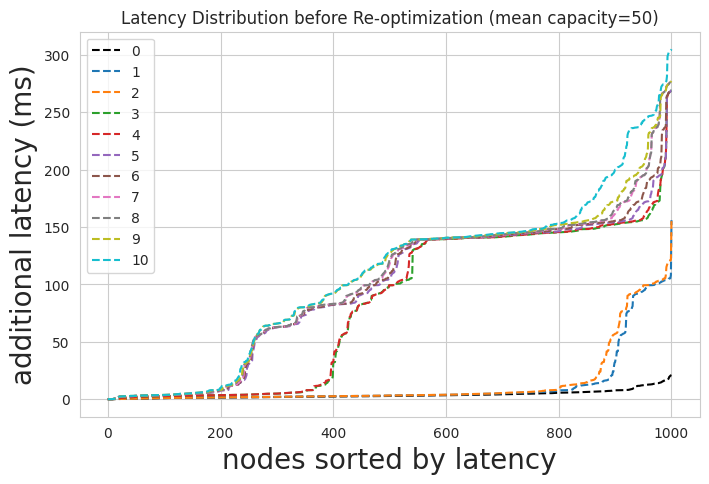

Means:  {'0': 3.85, '1': 12.34, '2': 14.1, '3': 82.18, '4': 82.81, '5': 95.43, '6': 97.07, '7': 99.93, '8': 100.39, '9': 103.61, '10': 107.95}
Quantiles:  {'0': 7.78, '1': 32.27, '2': 57.05, '3': 152.39, '4': 152.8, '5': 154.28, '6': 155.39, '7': 161.64, '8': 165.04, '9': 172.38, '10': 199.93}


In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i, df in enumerate(evaluations):
    l = str(i)
    sv = df["latency_distribution"] - coord_list[i]["latency"]
    sv = sv.sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution before Re-optimization (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

## Test Reoptimization

In [42]:
i = 0
ndf = prim_df.copy()
ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
evaluations[i] = edf
print(df["oindex"].nunique())
df

Level 0 CH number:  1000
--------Balancing load for 20 clusters to 0
Clusters processed: 0
Clusters processed: 10
Level 1 CH number:  130
--------Balancing load for 8 clusters to 0
Clusters processed: 0
Level 2 CH number:  25
--------Balancing load for 3 clusters to 0
Clusters processed: 0
Level 3 CH number:  6
1001


,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,71.925332,25.565323,coordinator,-1,<NA>,<NA>,<NA>,50,41,4,<NA>,9
1,1,24.775013,11.958341,worker,1,1,0,1,50,50,0,113,0
2,2,5.770977,8.497964,worker,1,1,0,1,50,50,0,896,0
3,3,30.952786,-3.329505,worker,15,1,0,1,50,50,0,959,0
4,4,18.231240,4.925715,worker,1,27,0,7,50,50,0,757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,996,88.052679,11.635696,worker,9,1,0,1,50,50,0,604,0
1093,997,34.643330,-22.089226,worker,13,1,0,1,50,50,0,64,0
1094,998,20.830278,17.439655,worker,1,1,0,1,50,50,0,339,0
1095,999,36.871673,9.978153,worker,15,12,0,12,50,50,0,276,0


In [43]:
for i, nodes in changed_nodes_dict.items():
    for node_idx in nodes:
        print("processing node", i, node_idx)
        df_re, opt_dict, resource_limit, level = nemo.remove_node(node_idx)
        node = prim_df.iloc[node_idx].to_dict()
        node["x"] = coord_list[i].iloc[node_idx]["x"]
        node["y"] = coord_list[i].iloc[node_idx]["y"]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node["oindex"] = node_idx
        node_idx, df_re, resource_limit = nemo.add_node(node)
        if resource_limit:
            print("Overloaded!!!!!!!!!!!!!!!!")

    update_df = coord_list[i][["x", "y"]]
    df = util.update_coordinates(df_re, update_df)
    edf = evaluate(df)
    evaluations[i] = edf.copy()

processing node 1 242
Adding node with index 242
processing node 1 311
Adding node with index 311
balancing required for clusters [5]
reoptimizing clusters dict_keys([5])
Level 1 CH number:  22
--------Balancing load for 1 clusters to 0
Clusters processed: 0
Level 2 CH number:  4
processing node 1 106
Adding node with index 106
processing node 1 739
Adding node with index 739
processing node 1 406
Adding node with index 406
processing node 1 491
Adding node with index 491
processing node 1 159
Adding node with index 159
processing node 1 93
Adding node with index 93
processing node 1 69
Adding node with index 69
balancing required for clusters [10]
reoptimizing clusters dict_keys([10])
Level 1 CH number:  49
--------Balancing load for 1 clusters to 0
Clusters processed: 0
Level 2 CH number:  5
--------Balancing load for 1 clusters to 0
Clusters processed: 0
Level 3 CH number:  1
--------Balancing load for 1 clusters to 0
Clusters processed: 0
Level 4 CH number:  1
Overloaded!!!!!!!!!!!

NameError: name 'evaluations' is not defined

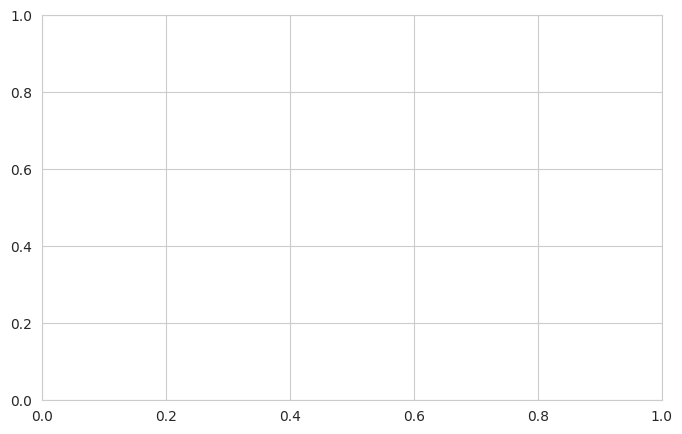

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i in range(len(evaluations)):
    l = str(i)
    s1 = evaluations[i].sort_index()["latency_distribution"]
    s2 = coord_list[i].sort_index()["latency"]
    sv = (s1 - s2).sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv = sv.to_numpy()

    if i == 0:
        ax1.plot(sv, label=l, linestyle="--", color="black")
    else:
        ax1.plot(sv, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution after Re-optimization (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)